# Support Vector Machine Algorithm (SVM)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 18/08/2024

This notebook was created by dr. Saad Laouadi on August 18th, 2024 as part of a series on anomaly detection algorithms. This notebook is considered as a suplementary material for OCSVM algorithm Outlier Detector.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

from sklearn.svm import OneClassSVM

import optuna
from optuna.samplers import TPESampler

---

### 1. What is a Kernel?

In machine learning, particularly in Support Vector Machines (SVMs), a **kernel** is a function that transforms the input data into a higher-dimensional space. This transformation allows the algorithm to find a linear separation between classes that are not linearly separable in the original input space.

### 2. Why Use Kernels?

- **Non-linearly Separable Data**: In many real-world scenarios, data cannot be separated by a straight line (or a hyperplane in higher dimensions). Kernels enable the transformation of data into a higher-dimensional space where a linear separator might exist.
- **Implicit Mapping**: Instead of explicitly mapping data to a high-dimensional space (which could be computationally expensive), kernels allow us to compute the dot product in the high-dimensional space without ever needing to compute the coordinates in that space explicitly. This process is known as the **kernel trick**.

### 3. Mathematical Explanation

Consider a dataset with features $\mathbf{x}_i$ and corresponding labels $y_i$. In a linear SVM, the decision boundary is defined by a hyperplane:

$$\mathbf{w} \cdot \mathbf{x} + b = 0$$

where $\mathbf{w}$ is the weight vector and $b$ is the bias term.

For data that is not linearly separable, we transform the input $\mathbf{x}$ into a higher-dimensional space using a mapping function $\phi(\mathbf{x})$:

$$
\mathbf{w} \cdot \phi(\mathbf{x}) + b = 0
$$

Instead of computing $\phi(\mathbf{x})$ explicitly, we use a kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$ that computes the dot product in the transformed space:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i) \cdot \phi(\mathbf{x}_j)
$$

### 4. Types of Kernels

- **Linear Kernel (`'linear'`)**:
  - **Function**: $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$
  - **Usage**: Best for linearly separable data. No transformation is applied, and the SVM finds a linear decision boundary in the original space.
  - **Mathematical Interpretation**: The linear kernel directly computes the dot product between two data points, keeping them in the original space.

- **Polynomial Kernel (`'poly'`)**:
  - **Function**: $K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i \cdot \mathbf{x}_j + c)^d$
  - **Parameters**:
    - $d$: Degree of the polynomial.
    - $c$: A constant to control the influence of higher-order terms.
  - **Usage**: Useful for capturing interactions between features up to a certain degree.
  - **Mathematical Interpretation**: Maps the original features into a polynomial space, allowing the SVM to capture non-linear relationships.

- **Radial Basis Function (RBF) Kernel (`'rbf'`)**:
  - **Function**: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{||\mathbf{x}_i - \mathbf{x}_j||^2}{2\sigma^2}\right)$
  - **Parameters**:
    - $\sigma$: Controls the width of the Gaussian function.
  - **Usage**: Very popular and effective for many types of data, especially when the relationship between classes is highly non-linear.
  - **Mathematical Interpretation**: Measures similarity between points based on their distance. The closer the points are, the higher the kernel value, and vice versa. This allows the SVM to create complex decision boundaries.

- **Sigmoid Kernel (`'sigmoid'`)**:
  - **Function**: $K(\mathbf{x}_i, \mathbf{x}_j) = \tanh(\alpha \mathbf{x}_i \cdot \mathbf{x}_j + c)$
  - **Parameters**:
    - $\alpha$: Scaling factor.
    - $c$: A constant.
  - **Usage**: Sometimes used in neural networks as an activation function, but less common in SVMs.
  - **Mathematical Interpretation**: Creates an S-shaped curve, similar to a neural network's activation function, which can model more complex relationships.

- **Precomputed Kernel (`'precomputed'`)**:
  - **Function**: User-defined.
  - **Usage**: If the kernel matrix is computed externally, it can be directly supplied to the SVM.
  - **Mathematical Interpretation**: Allows for custom-defined kernels that might be specific to the problem or dataset.

### 5. Statistical Perspective

From a statistical standpoint, the kernel function defines the similarity measure between data points. By selecting an appropriate kernel, you can control the flexibility of the decision boundary and the model's ability to generalize to unseen data.

- **Bias-Variance Tradeoff**: A more complex kernel (like RBF) can reduce bias by capturing intricate patterns but may increase variance, leading to overfitting. Simpler kernels (like linear) have lower variance but higher bias.

### 6. Choosing the Right Kernel

The choice of kernel depends on the nature of your data:

- **Linear Kernel**: Use when data is linearly separable.
- **Polynomial Kernel**: Use when interactions between features are polynomial in nature.
- **RBF Kernel**: Use when the relationship between classes is highly non-linear.
- **Sigmoid Kernel**: Less common but can be useful in specific cases where the data has an S-shaped decision boundary.


Kernels are a powerful tool in SVMs, allowing them to handle a wide range of data types by transforming the input space in ways that make complex patterns easier to model. The right kernel can significantly enhance the performance of an SVM by enabling it to find an appropriate decision boundary, even in cases where classes are not linearly separable.


### Types of Radial Basis Functions (RBF)

Radial Basis Functions (RBF) are a class of functions used as a kernel in Support Vector Machines (SVMs) and other machine learning algorithms. The most common type of RBF is the Gaussian RBF, but there are several other types. Here are the main types of RBFs:

#### 1. Gaussian RBF (also known as Gaussian Kernel or Squared Exponential RBF)
- **Function**: 
  $$
  K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right)
  $$
- **Description**: The Gaussian RBF is the most widely used RBF kernel. It creates a bell-shaped curve, where the influence of a training point decreases exponentially with distance from the point. The parameter $$\gamma$$ controls the width of the kernel.
- **Use Case**: Commonly used in SVMs for classification and regression tasks.

#### 2. Multiquadric RBF
- **Function**: 
  $$
  K(x, x') = \sqrt{\|x - x'\|^2 + c^2}
  $$
- **Description**: The Multiquadric RBF grows as the distance increases. The parameter $$c$$ controls the flatness of the function.
- **Use Case**: Sometimes used in interpolation and approximation problems, especially where the data is non-uniformly distributed.

#### 3. Inverse Multiquadric RBF
- **Function**: 
  $$
  K(x, x') = \frac{1}{\sqrt{\|x - x'\|^2 + c^2}}
  $$
- **Description**: The Inverse Multiquadric RBF decreases with increasing distance, and it has a longer tail compared to the Gaussian RBF, meaning it can capture long-range dependencies more effectively.
- **Use Case**: Used in scattered data interpolation and geospatial data modeling.

#### 4. Linear RBF
- **Function**: 
  $$
  K(x, x') = x \cdot x'
  $$
- **Description**: The Linear RBF is essentially the linear kernel used in SVMs. It computes the inner product of the two input vectors.
- **Use Case**: Used when the data is linearly separable or when a linear decision boundary is desired.

#### 5. Thin Plate Spline RBF
- **Function**: 
  $$
  K(x, x') = \|x - x'\|^2 \log(\|x - x'\|)
  $$
- **Description**: The Thin Plate Spline RBF is based on the theory of thin-plate splines, and it grows similarly to the Multiquadric RBF but with a logarithmic factor.
- **Use Case**: Often used in surface fitting and spatial interpolation problems.

#### 6. Polyharmonic Spline RBF
- **Function**: 
  $$
  K(x, x') = \|x - x'\|^k
  $$
- **Description**: The Polyharmonic Spline RBF includes a class of functions where $$k$$ is a positive integer. The most common cases are $$k = 1$$ (linear), $$k = 3$$, and $$k = 5$$.
- **Use Case**: Used in applications requiring smooth interpolation.

#### 7. Power RBF
- **Function**: 
  $$
  K(x, x') = \|x - x'\|^k
  $$
- **Description**: Similar to Polyharmonic Spline but without the logarithmic term. The parameter $$k$$ controls the degree of the function.
- **Use Case**: Used in interpolation tasks, particularly in 3D modeling and computer graphics.

#### 8. Inverse Quadratic RBF
- **Function**: 
  $$
  K(x, x') = \frac{1}{\|x - x'\|^2 + c^2}
  $$
- **Description**: The Inverse Quadratic RBF is similar to the Gaussian RBF but with a different decay behavior, offering a steeper falloff with distance.
- **Use Case**: Used in applications where a sharper decision boundary is desired.

## Examples Explaining SVM Kernels

### Linear Kernel

In this section we generate synthetic data to illustrate the linear kernel in SVM algorithm.

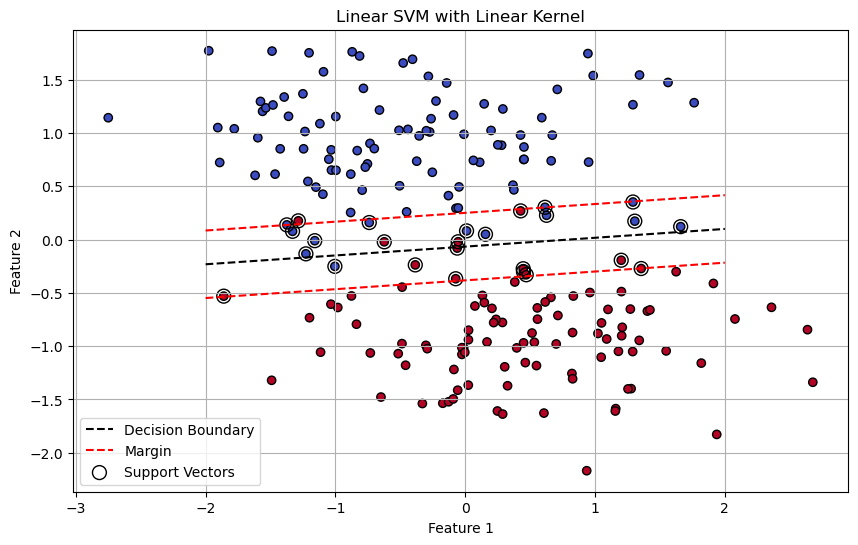

In [2]:
# Generate synthetic data
X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=1.0)

# Standardize the data (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a linear SVM model
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_scaled, y)

# Get the separating hyperplane
w = svm.coef_[0]
b = svm.intercept_[0]

# Compute the slope and intercept of the decision boundary
slope = -w[0] / w[1]
intercept = -b / w[1]

# Plot the data points and decision boundary
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Plot the decision boundary
x_vals = np.linspace(-2, 2, 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

# Plot the margins (support vectors)
margin = 1 / np.sqrt(np.sum(w ** 2))
plt.plot(x_vals, y_vals + margin, 'r--', label='Margin')
plt.plot(x_vals, y_vals - margin, 'r--')

# Highlight support vectors
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], 
            facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear SVM with Linear Kernel')
plt.legend()
plt.grid(True)
plt.show()

### Poly Kernel

The next example will illustrate the `poly` kernel in SVM. 

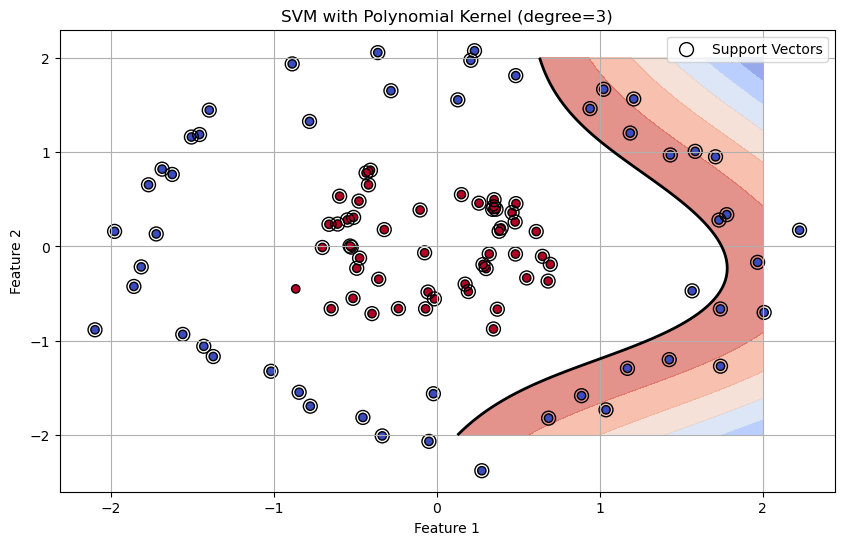

In [3]:
from sklearn.datasets import make_circles

# Generate synthetic data
X, y = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit an SVM model with a polynomial kernel
svm = SVC(kernel='poly', degree=3, C=1.0)
svm.fit(X_scaled, y)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Create a grid to plot decision boundaries
xx, yy = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and margins
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.coolwarm, alpha=0.6)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Plot the data points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Highlight support vectors
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with Polynomial Kernel (degree=3)')
plt.legend()
plt.grid(True)
plt.show()

### Radial Basis Kernel

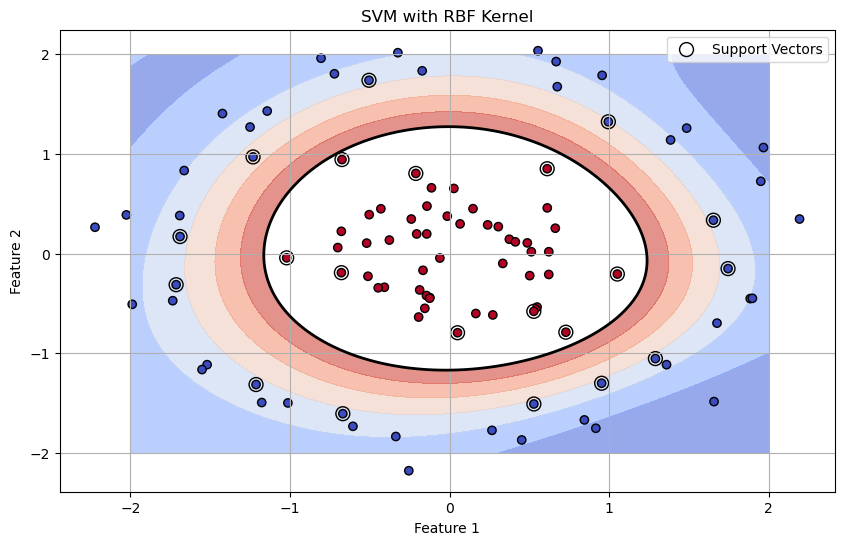

In [4]:
X, y = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit an SVM model with an RBF kernel
svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_scaled, y)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Create a grid to plot decision boundaries
xx, yy = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and margins
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.coolwarm, alpha=0.6)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Plot the data points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Highlight support vectors
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with RBF Kernel')
plt.legend()
plt.grid(True)
plt.show()

### Sigmoid Kernel

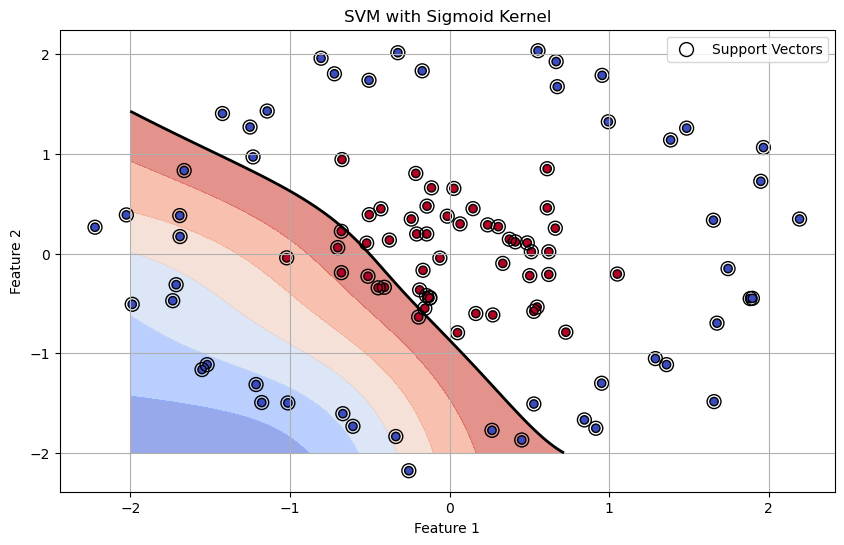

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Generate synthetic data
X, y = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit an SVM model with a Sigmoid kernel
svm = SVC(kernel='sigmoid', gamma='scale', C=1.0)
svm.fit(X_scaled, y)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Create a grid to plot decision boundaries
xx, yy = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and margins
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.coolwarm, alpha=0.6)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Plot the data points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Highlight support vectors
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM with Sigmoid Kernel')
plt.legend()
plt.grid(True)
plt.show()

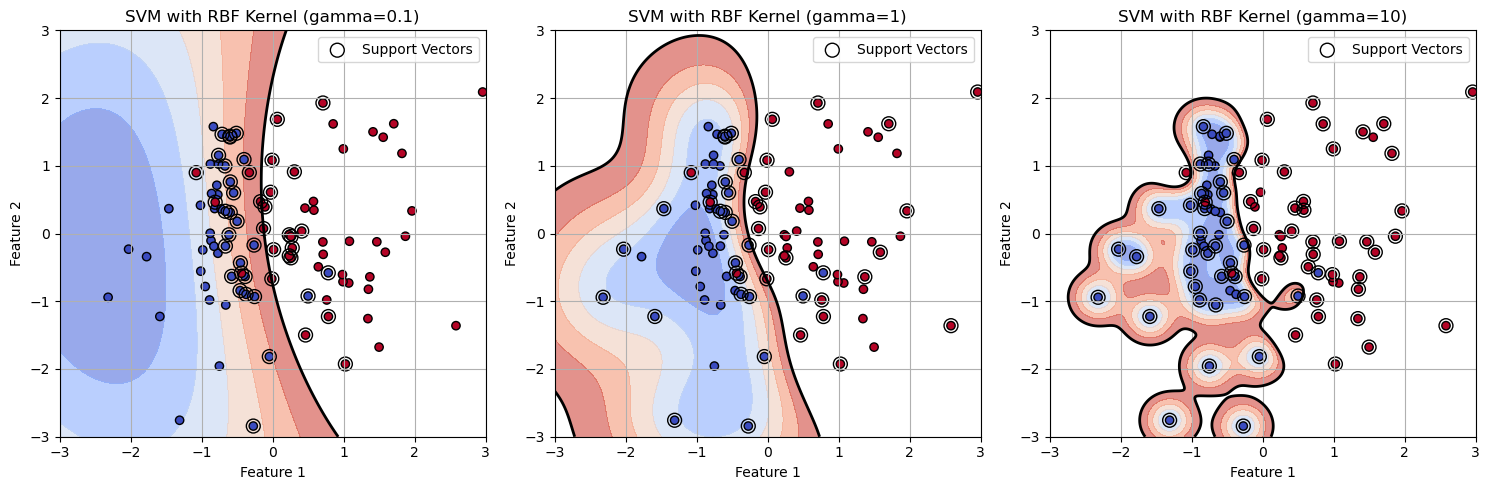

In [6]:
# Generate synthetic data
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define different gamma values
gamma_values = [0.1, 1, 10]

# Plot decision boundaries for different gamma values
plt.figure(figsize=(15, 5))
for i, gamma in enumerate(gamma_values):
    # Fit SVM model with RBF kernel and specified gamma
    svm = SVC(kernel='rbf', gamma=gamma, C=1.0)
    svm.fit(X_scaled, y)
    
    # Create a grid to plot decision boundaries
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and margins
    plt.subplot(1, 3, i + 1)
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.coolwarm, alpha=0.6)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

    # Plot the data points
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    # Highlight support vectors
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='k', s=100, label='Support Vectors')

    # Add labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'SVM with RBF Kernel (gamma={gamma})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

---

### Types of RBF kernels

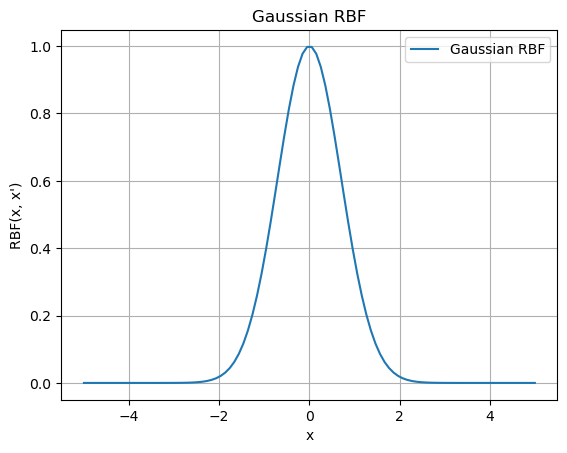

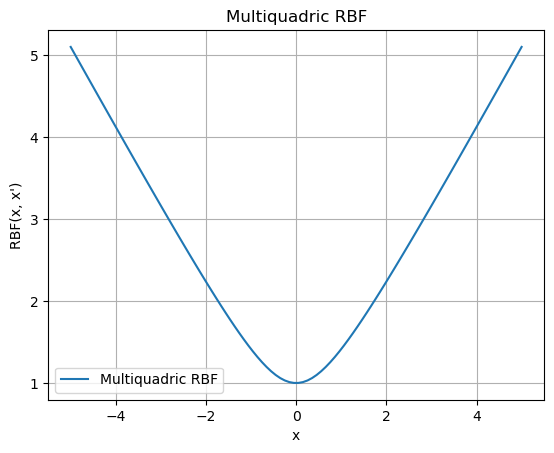

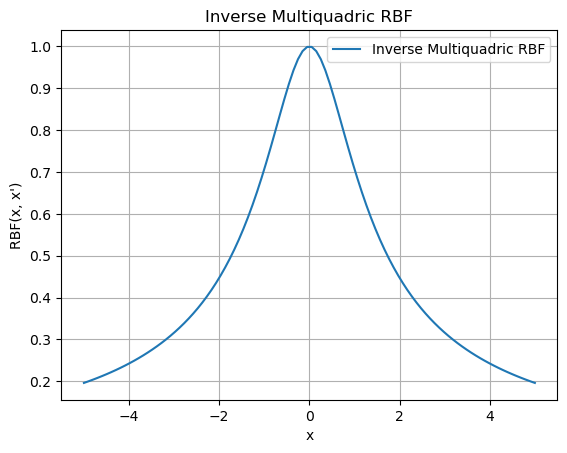

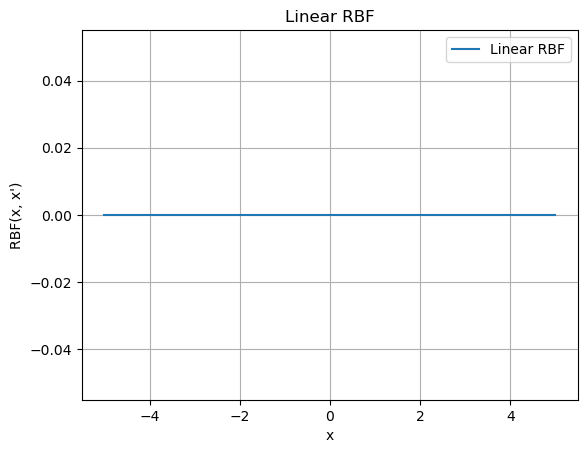

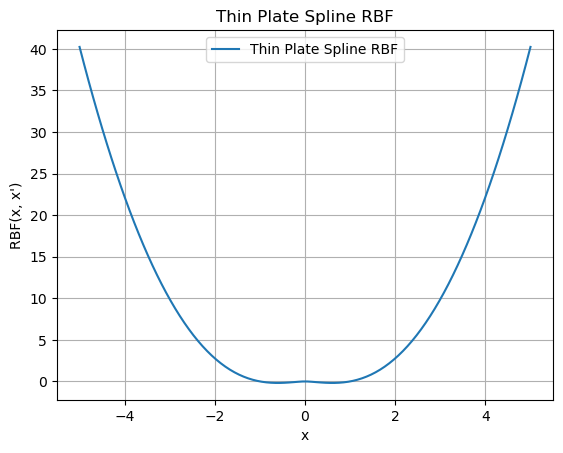

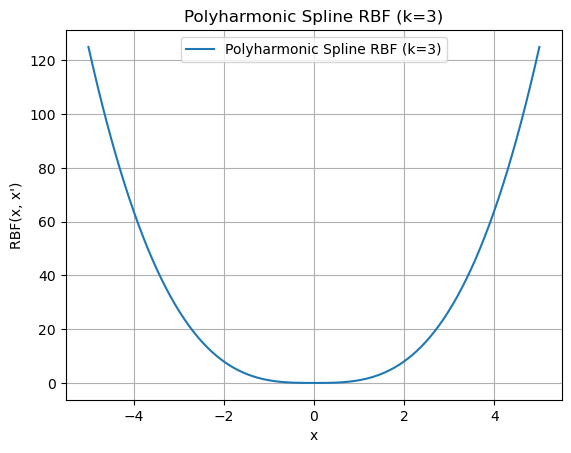

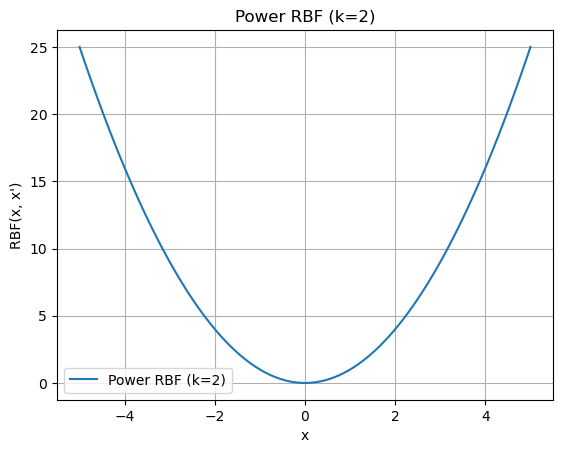

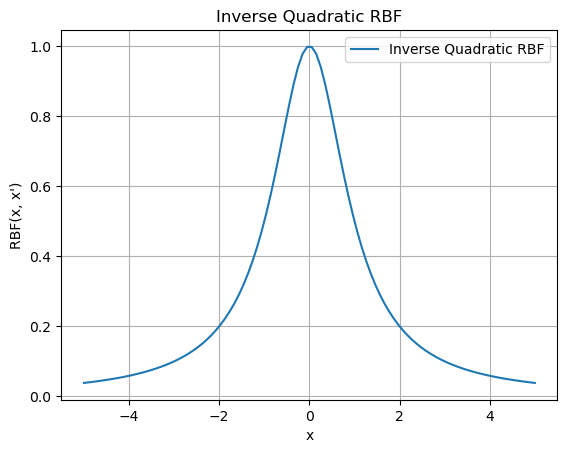

In [7]:
# Define the range for x
x = np.linspace(-5, 5, 100)
x_prime = 0  # Reference point (x')

# Function to plot RBFs
def plot_rbf(x, y, title):
    plt.plot(x, y, label=title)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('RBF(x, x\')')
    plt.legend()
    plt.grid(True)
    plt.show()

# Gaussian RBF
def gaussian_rbf(x, x_prime, gamma=1.0):
    return np.exp(-gamma * (x - x_prime) ** 2)

# Multiquadric RBF
def multiquadric_rbf(x, x_prime, c=1.0):
    return np.sqrt((x - x_prime) ** 2 + c ** 2)

# Inverse Multiquadric RBF
def inverse_multiquadric_rbf(x, x_prime, c=1.0):
    return 1.0 / np.sqrt((x - x_prime) ** 2 + c ** 2)

# Linear RBF
def linear_rbf(x, x_prime):
    return x * x_prime

# Thin Plate Spline RBF
def thin_plate_spline_rbf(x, x_prime):
    r = np.abs(x - x_prime)
    return r ** 2 * np.log(r + 1e-6)  # Added small constant to avoid log(0)

# Polyharmonic Spline RBF
def polyharmonic_spline_rbf(x, x_prime, k=3):
    r = np.abs(x - x_prime)
    return r ** k

# Power RBF
def power_rbf(x, x_prime, k=2):
    return np.abs(x - x_prime) ** k

# Inverse Quadratic RBF
def inverse_quadratic_rbf(x, x_prime, c=1.0):
    return 1.0 / ((x - x_prime) ** 2 + c ** 2)

# Plot each RBF

# Gaussian RBF
plot_rbf(x, gaussian_rbf(x, x_prime), "Gaussian RBF")

# Multiquadric RBF
plot_rbf(x, multiquadric_rbf(x, x_prime), "Multiquadric RBF")

# Inverse Multiquadric RBF
plot_rbf(x, inverse_multiquadric_rbf(x, x_prime), "Inverse Multiquadric RBF")

# Linear RBF
plot_rbf(x, linear_rbf(x, x_prime), "Linear RBF")

# Thin Plate Spline RBF
plot_rbf(x, thin_plate_spline_rbf(x, x_prime), "Thin Plate Spline RBF")

# Polyharmonic Spline RBF (k=3)
plot_rbf(x, polyharmonic_spline_rbf(x, x_prime, k=3), "Polyharmonic Spline RBF (k=3)")

# Power RBF (k=2)
plot_rbf(x, power_rbf(x, x_prime, k=2), "Power RBF (k=2)")

# Inverse Quadratic RBF
plot_rbf(x, inverse_quadratic_rbf(x, x_prime), "Inverse Quadratic RBF")

---

### Example Illustrating Gamma Factor

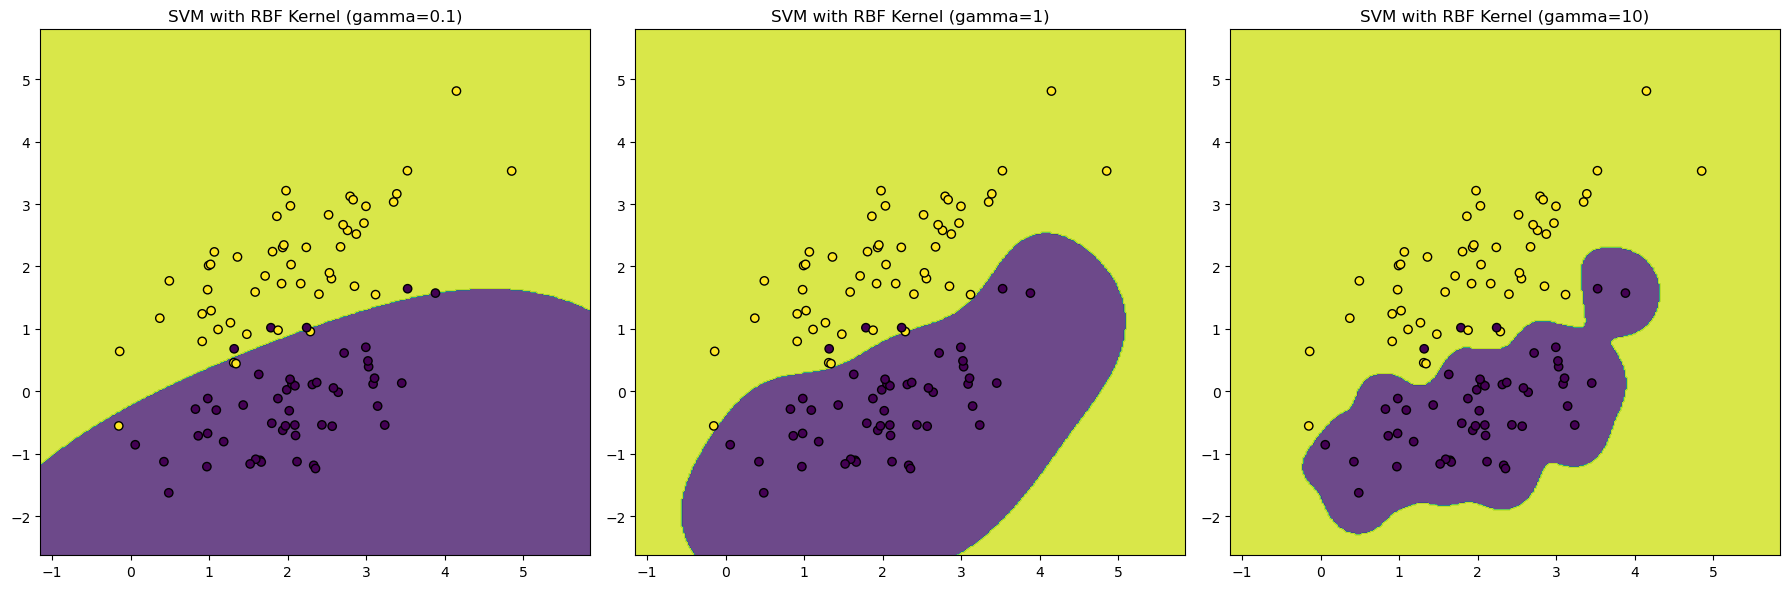

In [8]:
# Generate synthetic dataset
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X += 2 * np.random.RandomState(2).uniform(size=X.shape)

# Function to plot SVM decision boundaries
def plot_svm_decision_boundary(X, y, model, title, ax):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    ax.set_title(title)

# Apply SVM with different RBF kernels
def apply_svm_rbf(X, y, gamma_values):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of subplots
    for ax, gamma in zip(axes, gamma_values):
        model = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gamma))
        model.fit(X, y)
        plot_svm_decision_boundary(X, y, model, f"SVM with RBF Kernel (gamma={gamma})", ax)
    plt.tight_layout()
    plt.show()

# Example: Using different gamma values for RBF kernel
gamma_values = [0.1, 1, 10]
apply_svm_rbf(X, y, gamma_values)

---

## One-Class Support Vector Machine (OCSVM)

One-Class Support Vector Machine (OCSVM) is an unsupervised learning algorithm specifically designed for anomaly detection. Unlike traditional SVMs used for classification, which rely on labeled data to learn decision boundaries between different classes, OCSVM is tailored for scenarios where the goal is to identify whether a data point belongs to the "normal" class or is an outlier (anomaly).

### Theoretical Background

The core idea behind OCSVM is to learn a decision function that can separate the majority of the data points (considered as "normal") from the rest of the feature space. The decision boundary is designed to encapsulate the normal data points, effectively creating a region where any point lying outside is considered an outlier.

### Mathematical Formulation

Given a set of training data points $\{x_1, x_2, \dots, x_n\}$ where each $x_i$ is a feature vector, OCSVM aims to find a function $f(x)$ that is positive for the "normal" points and negative for outliers. This is achieved by solving the following optimization problem:

$$
\min_{w, \rho, \xi} \frac{1}{2} \|w\|^2 + \frac{1}{\nu n} \sum_{i=1}^n \xi_i - \rho
$$

subject to:

$$
(w \cdot \phi(x_i)) \geq \rho - \xi_i, \quad \xi_i \geq 0
$$

Here:
- $w$ is the normal vector to the hyperplane.
- $\rho$ is the margin.
- $\xi_i$ are slack variables that allow some data points to be within the margin.
- $\nu$ is a parameter that controls the fraction of outliers in the training data and the number of support vectors.

The function \( \phi(x) \) maps the input features into a higher-dimensional space, allowing the OCSVM to create a more complex decision boundary using kernels such as the Radial Basis Function (RBF), polynomial, or linear kernels.

### Kernel Trick

OCSVM can use different kernel functions to handle data with complex structures. The kernel trick allows OCSVM to implicitly map the data into a higher-dimensional space without having to compute the coordinates explicitly. This makes it possible to find non-linear decision boundaries in the original feature space.

Common kernel choices include:
- **Linear Kernel**: $k(x, y) = x \cdot y$
- **Polynomial Kernel**: $k(x, y) = (x \cdot y + c)^d$
- **Radial Basis Function (RBF) Kernel**: $k(x, y) = \exp(-\gamma \|x - y\|^2)$
- **Sigmoid Kernel**: $k(x, y) = \tanh(\alpha x \cdot y + c)$

### Applications of OCSVM

OCSVM is widely used in various domains for anomaly detection, including:
- **Network Intrusion Detection**: Identifying unusual patterns in network traffic that may indicate security breaches.
- **Fraud Detection**: Detecting fraudulent transactions or behaviors that deviate from normal patterns.
- **Manufacturing**: Monitoring the production process to identify defective products.
- **Healthcare**: Identifying abnormal patterns in medical data, such as early detection of diseases.

### Advantages and Limitations

**Advantages**:
- **Unsupervised Learning**: OCSVM does not require labeled data, making it suitable for situations where only "normal" data is available.
- **Flexibility**: The use of different kernels allows OCSVM to handle various types of data, from linear to highly non-linear distributions.

**Limitations**:
- **Sensitivity to Parameter Selection**: The performance of OCSVM can be sensitive to the choice of kernel and parameters such as $\nu$ and $\gamma$.
- **Computational Complexity**: OCSVM can be computationally expensive, especially for large datasets, due to the need to solve a quadratic optimization problem.


Overall, One-Class Support Vector Machine (OCSVM) is a powerful tool for anomaly detection in scenarios where only "normal" data is available. By learning a decision boundary that encapsulates the majority of the data, OCSVM can effectively identify outliers and anomalies across various applications. However, careful selection of parameters and kernels is crucial to ensure optimal performance.

### One Class SVM Example

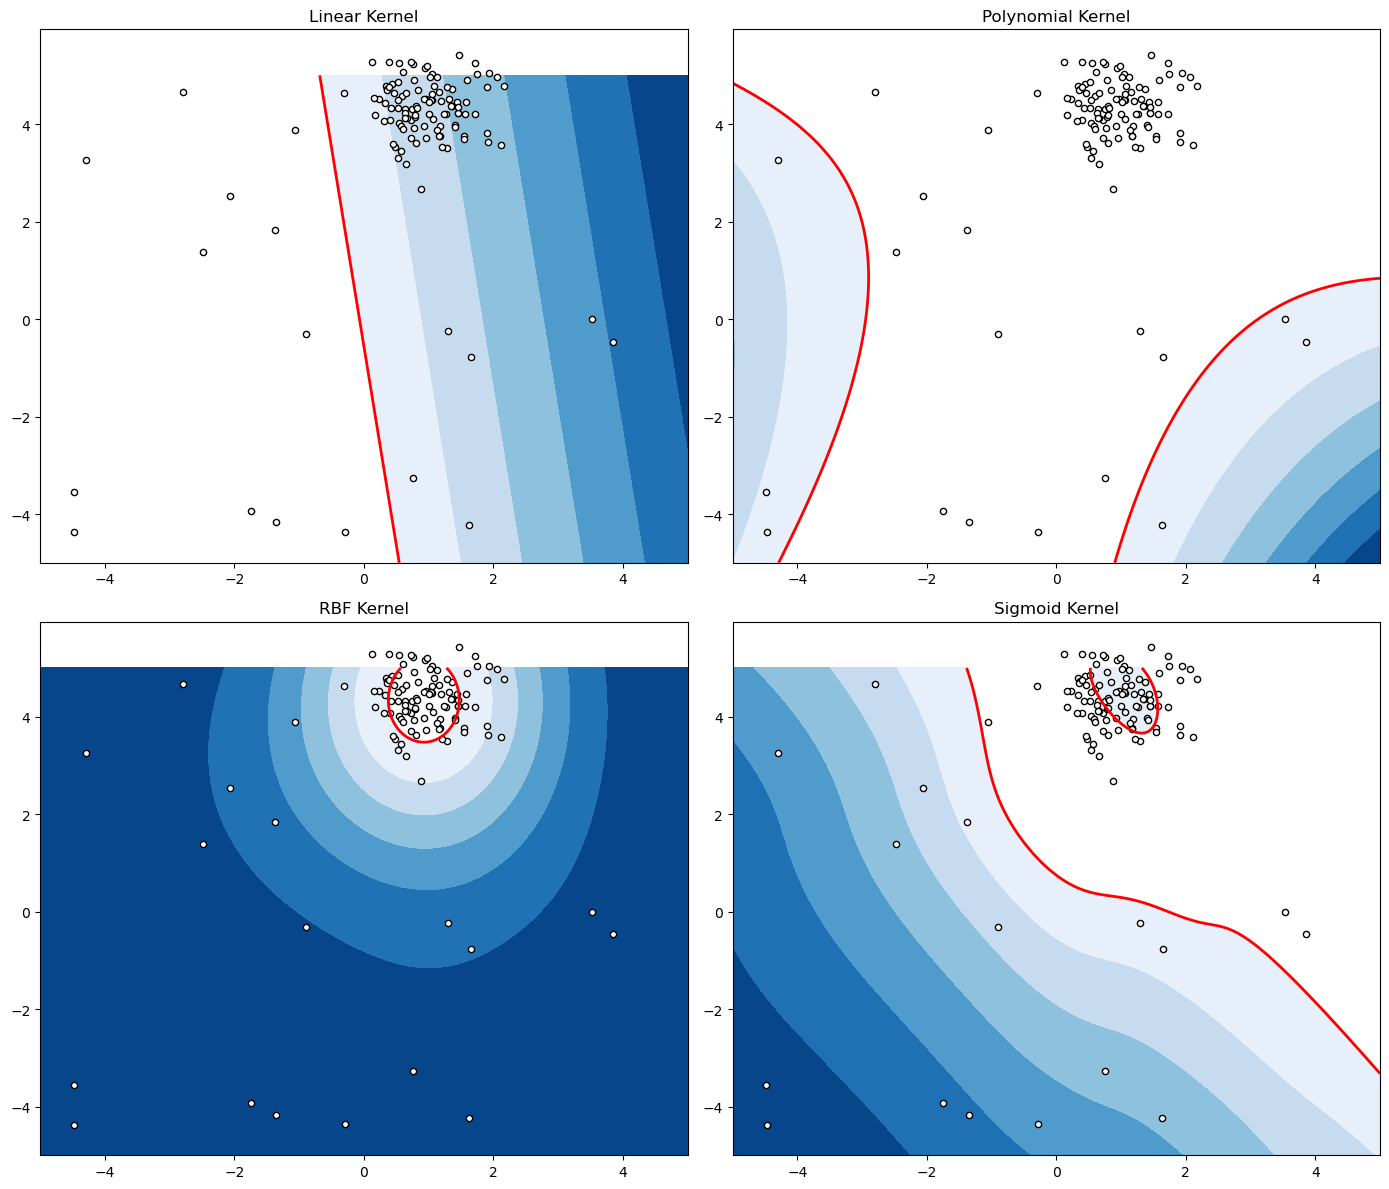

In [9]:
# Generate synthetic data
X, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.5, random_state=0)
X = np.vstack([X, np.random.uniform(low=-5, high=5, size=(20, 2))])

# Define the kernels to be used
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
titles = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel', 'Sigmoid Kernel']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Apply OCSVM with different kernels and plot the decision boundaries
for i, kernel in enumerate(kernels):
    model = make_pipeline(StandardScaler(), OneClassSVM(kernel=kernel, gamma='auto'))
    model.fit(X)
    
    # Plot decision boundary
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    axes[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    axes[i].scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

## OCSVM Explained Via Code

Here we will generate synthetic data to illustrate One-Class Support Vector Machine (OCSVM), the purpose of this code is to demonstrate the key points:

1. **Unsupervised Learning**: Show how OCSVM can be applied to detect anomalies in a dataset without labels.
2. **Flexibility**: Use different kernels to illustrate how OCSVM can handle various types of data distributions.
3. **Sensitivity to Parameter Selection**: Demonstrate how the performance of OCSVM changes with different values of the parameters \(\nu\) and \(\gamma\).
4. **Computational Complexity**: Highlight the increased computation time with larger datasets.

In [10]:
# X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, random_state=42)

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Function to plot decision boundaries
# def plot_decision_boundary(X, model, title):
#     xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
#                          np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
#     Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
#     plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
#     plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
#     plt.title(title)
#     plt.show()

# # Example 1: Flexibility with different kernels
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# for kernel in kernels:
#     ocsvm = OneClassSVM(kernel=kernel, gamma='auto').fit(X_scaled)
#     plot_decision_boundary(X_scaled, ocsvm, f"OCSVM with {kernel} kernel")

# # Example 2: Sensitivity to parameter selection (nu and gamma)
# nu_values = [0.01, 0.1, 0.5]
# gamma_values = [0.1, 1, 10]

# plt.figure(figsize=(15, 10))
# for i, nu in enumerate(nu_values):
#     for j, gamma in enumerate(gamma_values):
#         ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma).fit(X_scaled)
#         plt.subplot(len(nu_values), len(gamma_values), i * len(gamma_values) + j + 1)
#         plot_decision_boundary(X_scaled, ocsvm, f"nu={nu}, gamma={gamma}")
# plt.tight_layout()
# plt.show()

# # Example 3: Computational complexity illustration (using time)
# import time

# # Increase dataset size
# X_large, _ = make_blobs(n_samples=10000, centers=1, cluster_std=1.0, random_state=42)
# X_large_scaled = scaler.fit_transform(X_large)

# start_time = time.time()
# ocsvm = OneClassSVM(kernel='rbf', gamma='auto').fit(X_large_scaled)
# end_time = time.time()

# print(f"Time taken to fit OCSVM on large dataset: {end_time - start_time:.2f} seconds")

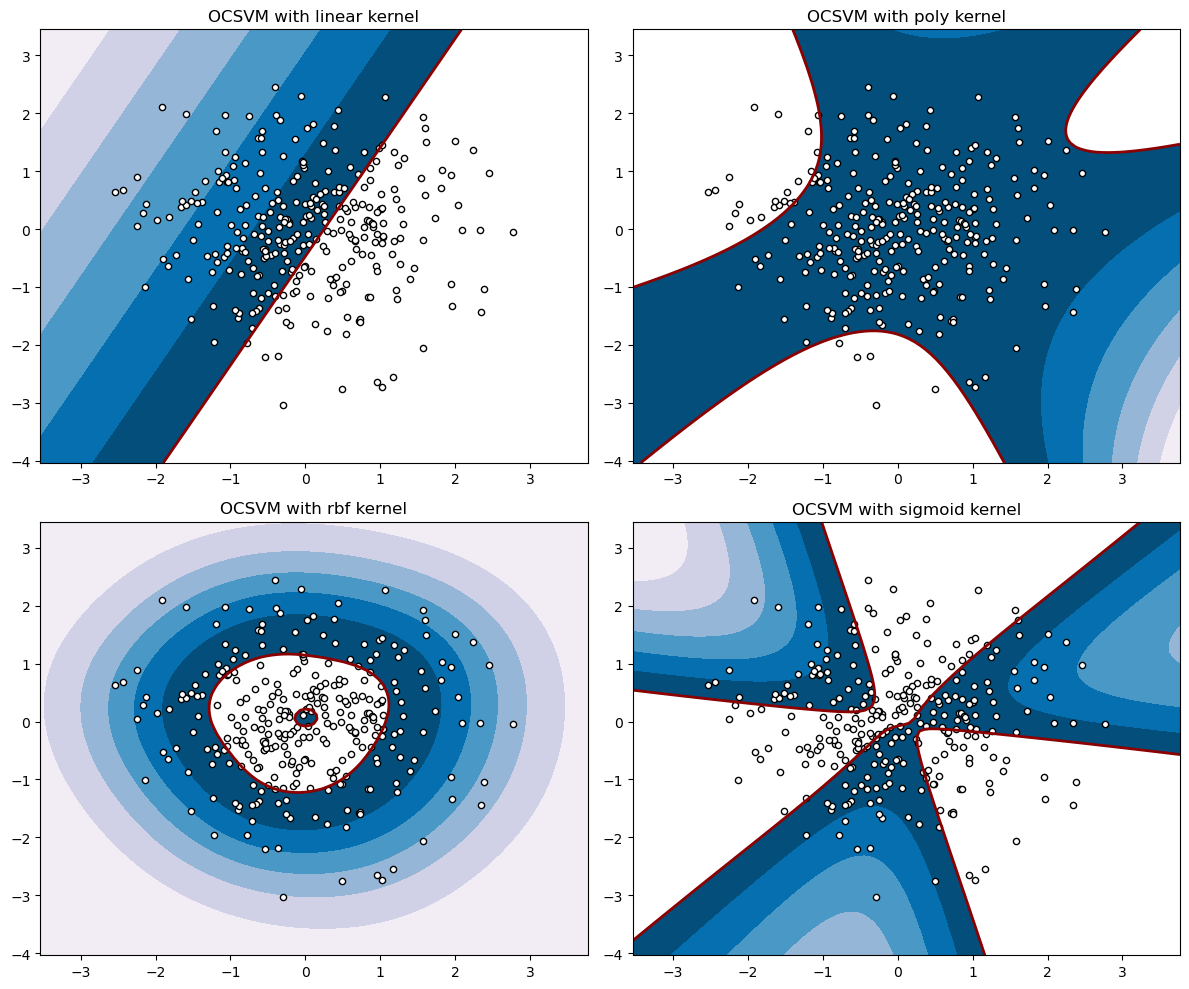

In [11]:
X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, random_state=0)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to plot decision boundaries
def plot_decision_boundary(X, model, title, ax):
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    ax.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
    ax.set_title(title)

# Example 1: Flexibility with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, kernel in enumerate(kernels):
    ax = axes[i // 2, i % 2]
    ocsvm = OneClassSVM(kernel=kernel, gamma='auto').fit(X_scaled)
    plot_decision_boundary(X_scaled, ocsvm, f"OCSVM with {kernel} kernel", ax)
plt.tight_layout()
plt.show()

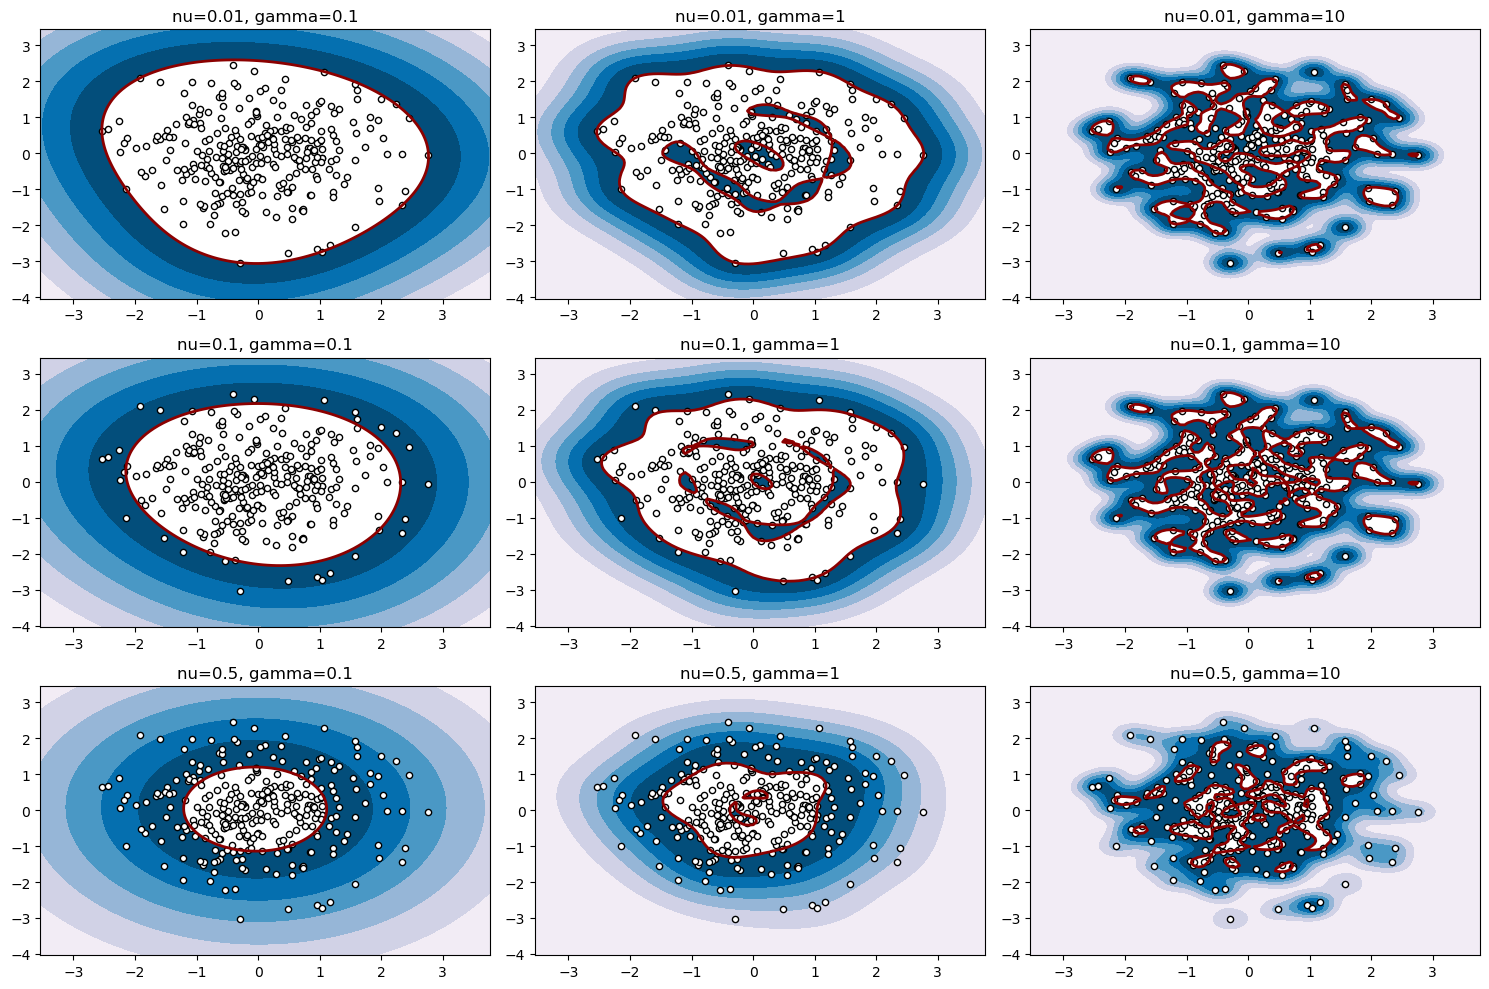

In [12]:
# Example 2: Sensitivity to parameter selection (nu and gamma)
nu_values = [0.01, 0.1, 0.5]
gamma_values = [0.1, 1, 10]
fig, axes = plt.subplots(len(nu_values), len(gamma_values), figsize=(15, 10))
for i, nu in enumerate(nu_values):
    for j, gamma in enumerate(gamma_values):
        ax = axes[i, j]
        ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma).fit(X_scaled)
        plot_decision_boundary(X_scaled, ocsvm, f"nu={nu}, gamma={gamma}", ax)
plt.tight_layout()
plt.show()

### Computational complexity illustration (using time: Timing OCSVM Algorithm

Here we will generate synthetic data and increase the number to data gradually and time training OCSVM each time. 

In [15]:
def fit_ocsvm_with_timing(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    start_time = time.time()
    ocsvm = OneClassSVM(kernel='rbf', gamma='auto').fit(X_scaled)
    end_time = time.time()

    print(f"Time taken to fit OCSVM on dataset with {len(X)} samples: {end_time - start_time:.2f} seconds")

sample_sizes = [1000, 5000, 10000, 20000, 50000, 100000]

for size in sample_sizes:
    X_large, _ = make_blobs(n_samples=size, centers=1, cluster_std=1.0, random_state=0)
    fit_ocsvm_with_timing(X_large)

Time taken to fit OCSVM on dataset with 1000 samples: 0.01 seconds
Time taken to fit OCSVM on dataset with 5000 samples: 0.21 seconds
Time taken to fit OCSVM on dataset with 10000 samples: 1.02 seconds
Time taken to fit OCSVM on dataset with 20000 samples: 4.20 seconds
Time taken to fit OCSVM on dataset with 50000 samples: 26.60 seconds
Time taken to fit OCSVM on dataset with 100000 samples: 108.49 seconds


## Hyperparameter Tuning OCSVM

### Computational Efficiency

In [18]:
X_large, _ = make_blobs(n_samples=50000, centers=1, cluster_std=1.0, random_state=42)

scaler = StandardScaler()
X_large_scaled = scaler.fit_transform(X_large)

# Objective function for Optuna to optimize
def objective(trial):
    # Suggest hyperparameters to optimize
    nu = trial.suggest_float('nu', 0.01, 0.5, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Initialize and fit the OCSVM model with suggested hyperparameters
    ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    
    # Measure time taken to fit the model
    start_time = time.time()
    ocsvm.fit(X_large_scaled)
    end_time = time.time()

    # Evaluate the model (for OCSVM, we can only measure time since labels aren't available)
    print(f"Time taken: {end_time - start_time:.2f} seconds with nu={nu} and gamma={gamma}")
    
    return end_time - start_time

# Create a study to optimize the objective function
study = optuna.create_study(direction="minimize", sampler=TPESampler())
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(study.best_params)

# Fit the model with the best hyperparameters
best_ocsvm = OneClassSVM(kernel='rbf', nu=study.best_params['nu'], gamma=study.best_params['gamma'])

start_time = time.time()
best_ocsvm.fit(X_large_scaled)
end_time = time.time()

print(f"Time taken with best hyperparameters: {end_time - start_time:.2f} seconds")

[I 2024-08-18 00:56:36,398] A new study created in memory with name: no-name-8f4386f0-0ea4-46f0-8c66-b2157ca4d488
[I 2024-08-18 00:56:45,227] Trial 0 finished with value: 8.827927112579346 and parameters: {'nu': 0.1252245959992422, 'gamma': 'scale'}. Best is trial 0 with value: 8.827927112579346.


Time taken: 8.83 seconds with nu=0.1252245959992422 and gamma=scale


[I 2024-08-18 00:56:46,064] Trial 1 finished with value: 0.8365411758422852 and parameters: {'nu': 0.012366805569113588, 'gamma': 'scale'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 0.84 seconds with nu=0.012366805569113588 and gamma=scale


[I 2024-08-18 00:56:47,155] Trial 2 finished with value: 1.090829610824585 and parameters: {'nu': 0.01556670205153203, 'gamma': 'auto'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 1.09 seconds with nu=0.01556670205153203 and gamma=auto


[I 2024-08-18 00:56:49,094] Trial 3 finished with value: 1.9378318786621094 and parameters: {'nu': 0.029559797739728853, 'gamma': 'scale'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 1.94 seconds with nu=0.029559797739728853 and gamma=scale


[I 2024-08-18 00:56:50,166] Trial 4 finished with value: 1.0712778568267822 and parameters: {'nu': 0.016400256934675613, 'gamma': 'scale'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 1.07 seconds with nu=0.016400256934675613 and gamma=scale


[I 2024-08-18 00:57:05,004] Trial 5 finished with value: 14.837176084518433 and parameters: {'nu': 0.20183837299021196, 'gamma': 'auto'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 14.84 seconds with nu=0.20183837299021196 and gamma=auto


[I 2024-08-18 00:57:13,337] Trial 6 finished with value: 8.33281683921814 and parameters: {'nu': 0.12392791237513395, 'gamma': 'scale'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 8.33 seconds with nu=0.12392791237513395 and gamma=scale


[I 2024-08-18 00:57:24,136] Trial 7 finished with value: 10.798448085784912 and parameters: {'nu': 0.14087433757225473, 'gamma': 'auto'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 10.80 seconds with nu=0.14087433757225473 and gamma=auto


[I 2024-08-18 00:57:35,065] Trial 8 finished with value: 10.928527116775513 and parameters: {'nu': 0.14441223292023547, 'gamma': 'scale'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 10.93 seconds with nu=0.14441223292023547 and gamma=scale


[I 2024-08-18 00:57:36,732] Trial 9 finished with value: 1.6659479141235352 and parameters: {'nu': 0.025284115847100844, 'gamma': 'auto'}. Best is trial 1 with value: 0.8365411758422852.


Time taken: 1.67 seconds with nu=0.025284115847100844 and gamma=auto
Best hyperparameters found:
{'nu': 0.012366805569113588, 'gamma': 'scale'}
Time taken with best hyperparameters: 0.83 seconds


### Performance-Based Hyperparameter Tuning